<a href="https://colab.research.google.com/github/juliobellano/CV_Notebooks/blob/main/HuggingPics2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingPics 🤗🖼️

Fine-tune Vision Transformers for regression problem. ("Guessthecorrelation.com")

In [1]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [2]:
import requests
import math
import time
import matplotlib.pyplot as plt
import shutil
import os
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/input.zip /content/input.zip

In [8]:
!cp /content/drive/MyDrive/vit_model_weights.pth /content/model.pth

In [9]:
!unzip input.zip -d /content/input

Streaming output truncated to the last 5000 lines.
  inflating: /content/input/correlation_assignment/images/sljirypk.png  
  inflating: /content/input/__MACOSX/correlation_assignment/images/._sljirypk.png  
  inflating: /content/input/correlation_assignment/images/ngxwdeml.png  
  inflating: /content/input/__MACOSX/correlation_assignment/images/._ngxwdeml.png  
  inflating: /content/input/correlation_assignment/images/idnpgecr.png  
  inflating: /content/input/__MACOSX/correlation_assignment/images/._idnpgecr.png  
  inflating: /content/input/correlation_assignment/images/nwujauvo.png  
  inflating: /content/input/__MACOSX/correlation_assignment/images/._nwujauvo.png  
  inflating: /content/input/correlation_assignment/images/hjpfpfmc.png  
  inflating: /content/input/__MACOSX/correlation_assignment/images/._hjpfpfmc.png  
  inflating: /content/input/correlation_assignment/images/gaigojuv.png  
  inflating: /content/input/__MACOSX/correlation_assignment/images/._gaigojuv.png  
  infla

In [3]:
data_dir = Path('input/correlation_assignment/images')

## Init Dataset and Split into Training and Validation Sets


In [4]:
df = pd.read_csv('input/correlation_assignment/responses.csv')

image_id = df['id'].values
labels = df['corr'].values
print(len(image_id))

150000


In [5]:
data_transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(0.5,))])
class ImageDataset(Dataset):
    def __init__(self, image_ids, labels, image_dir='input/correlation_assignment/images', transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        #get image pathhh
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_name}.png")

        #load image
        image = Image.open(img_path).convert('1')

        #apply transforms
        if self.transform:
            image = self.transform(image)

        #get label
        label = self.labels[idx]

        return image, label

In [6]:
X_train, X_val, y_train, y_val = train_test_split(image_id, labels, test_size=0.15, random_state=42, shuffle=True)
print(f"length of training dataset {len(X_train)}")
print(f"length of val dataset {len(X_val)}")

train_ds = ImageDataset(X_train, y_train, transform = data_transforms)
val_ds = ImageDataset(X_val, y_val, transform = data_transforms)

length of training dataset 127500
length of val dataset 22500


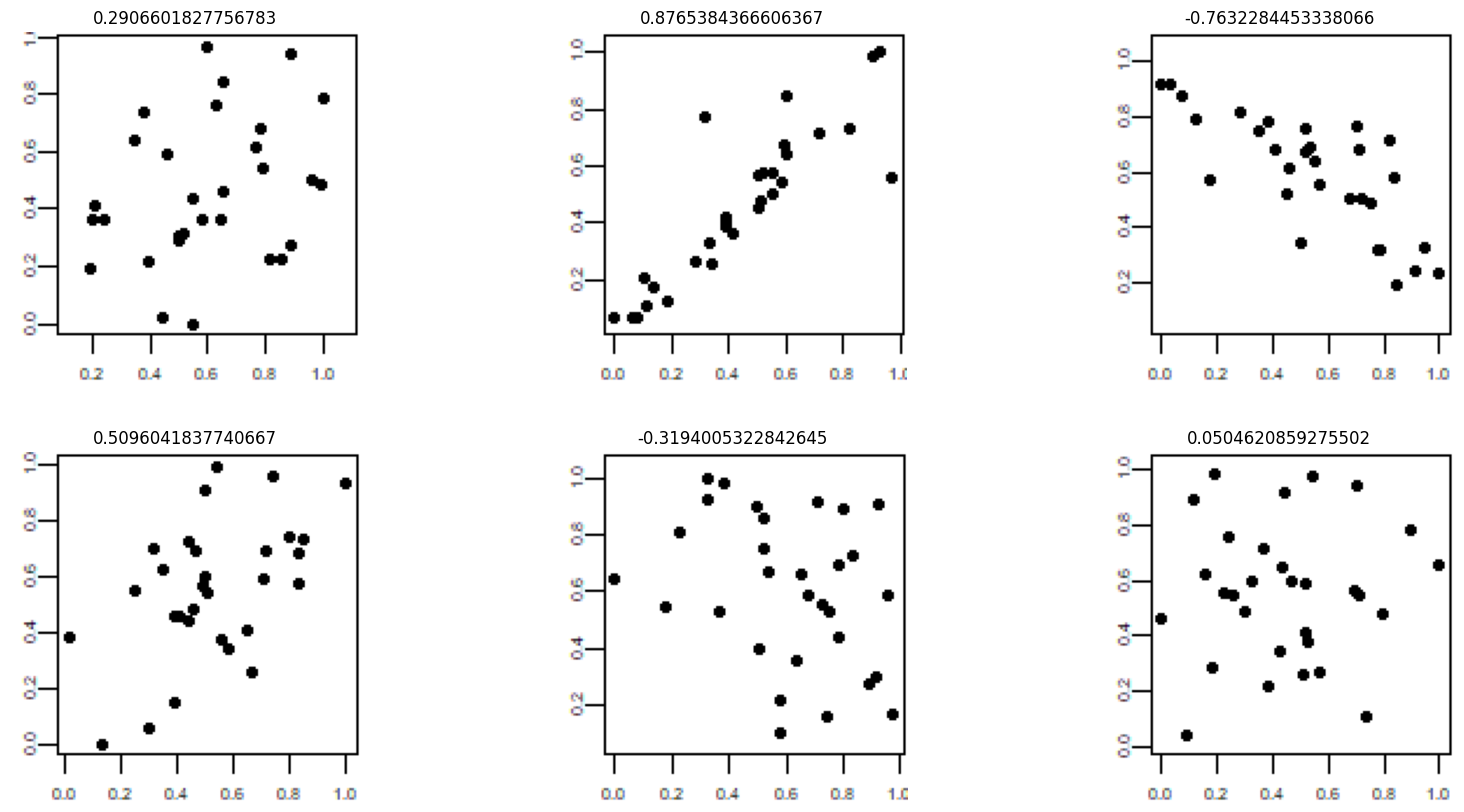

In [7]:
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.title(f'{y_train[i]}')
    img = plt.imread(f'/content/input/correlation_assignment/images/{X_train[i]}.png')
    plt.imshow(img)
    plt.axis('off')

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [8]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        processed_images = []
        for x in batch:
            img = x[0]

            # Convert from [-1,1] to [0,255] range
            img = ((img + 1) * 127.5).byte()

            # Convert grayscale to RGB using PIL
            # This works better than just repeating channels
            if img.shape[0] == 1:  # If single channel
                # Convert tensor to PIL
                pil_img = Image.fromarray(img[0].numpy())
                # Convert to RGB
                pil_img = pil_img.convert('RGB')
                processed_images.append(pil_img)
            else:
                processed_images.append(img)

        encodings = self.feature_extractor(processed_images, return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.float)
        return encodings

## Init Feature Extractor, Model, Data Loaders


In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=1,
    problem_type='regression'
)

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 1),
    torch.nn.Tanh()
)


collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=64, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this

# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [13]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.mse = torch.nn.MSELoss()


    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = self.mse(outputs.logits.squeeze(), batch['labels'])
        self.log(f"train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = outputs.logits.squeeze()
        loss = self.mse(preds, batch['labels'])
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.device

In [14]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='cuda', devices=1, precision=16, max_epochs=1)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode 
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Check if it Worked 😅

In [10]:
model.load_state_dict(torch.load("model.pth"))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [12]:
val_batch = next(iter(val_loader))
start_time = time.time()
outputs = model(**val_batch)
time = time.time() - start_time
print(f'Inference time for 1 batch: {time}')
print('Preds: ', outputs.logits.squeeze())
print('Labels:', val_batch['labels'])
model_output = outputs.logits.squeeze().detach().cpu().numpy()
labels_actual = val_batch['labels'].cpu().numpy()
print('model output:', model_output)
print('Labels:', labels_actual)



Inference time for 1 batch: 40.38187313079834
Preds:  tensor([ 0.4178, -0.6055, -0.5180, -0.4998,  0.5670, -0.6530, -0.4262,  0.3022,
         0.4415,  0.1707, -0.1023, -0.5255,  0.5452, -0.2525,  0.4916, -0.2635,
         0.5633, -0.6224, -0.0862,  0.2766, -0.8923,  0.5443,  0.8902,  0.0422,
         0.6443,  0.4154,  0.1820, -0.2472, -0.6071, -0.2650,  0.7653,  0.0633,
        -0.6995,  0.2575,  0.3962, -0.1290, -0.1486, -0.5786,  0.1857,  0.4681,
         0.2837,  0.4475, -0.0970, -0.6283, -0.0214, -0.0882,  0.1666,  0.4508,
         0.0931,  0.6924, -0.0591, -0.2128,  0.1736,  0.7185,  0.6855,  0.6138,
        -0.8454,  0.1158, -0.5342, -0.1657,  0.1473,  0.1924, -0.7270,  0.2268],
       grad_fn=<SqueezeBackward0>)
Labels: tensor([ 0.4139, -0.6147, -0.5249, -0.4835,  0.5729, -0.6997, -0.4155,  0.3311,
         0.4446,  0.1810, -0.1191, -0.5564,  0.5279, -0.2661,  0.4765, -0.2724,
         0.5362, -0.6487, -0.0952,  0.2665, -0.8696,  0.5268,  0.8870,  0.0266,
         0.6537,  0.40

In [42]:
model_output = outputs.logits.squeeze().detach().cpu().numpy()
print(model_output)
labels_actual = np.array(val_batch['labels'])

print(labels_actual)
print(model_output.shape)
print(labels_actual.shape)
results_df = pd.DataFrame({
    'actual': labels_actual,
    'predicted': model_output,
    'Accuracy (correlation)': np.corrcoef(labels_actual,model_output)[0,1],
    'absolute_error': np.abs(labels_actual - model_output)
})

results_df.to_csv('predictions_results.csv', index=False)

[ 0.41776422 -0.6055293  -0.51798356 -0.49976555  0.5669994  -0.6530468
 -0.4262104   0.3022369   0.44151273  0.17068815 -0.10233693 -0.5255354
  0.5452341  -0.25249007  0.49155816 -0.26353824  0.5633155  -0.6223519
 -0.08622064  0.27663127 -0.89227927  0.54428434  0.89015424  0.04217976
  0.64433956  0.41536835  0.181998   -0.24716198 -0.6070857  -0.26495832
  0.7653099   0.06333662 -0.6995308   0.25754395  0.39618576 -0.12896085
 -0.14856829 -0.5786208   0.18565933  0.46811935  0.28367817  0.4474845
 -0.09701054 -0.62830615 -0.02135096 -0.08819071  0.16656126  0.45075873
  0.09312033  0.6924089  -0.05906608 -0.2127608   0.17360818  0.71852916
  0.6855224   0.61375123 -0.8453924   0.1157569  -0.5342438  -0.16567245
  0.14728586  0.19239789 -0.72703594  0.22677152]
[ 0.41386083 -0.614705   -0.52492535 -0.4834765   0.5729495  -0.699679
 -0.4154679   0.33109364  0.44460288  0.18099903 -0.11905082 -0.55642617
  0.5278557  -0.2660921   0.4765133  -0.27239838  0.5362231  -0.6487073
 -0.0951

In [20]:
trainer.save_checkpoint("full_model.ckpt")

In [18]:
PATH = '/content/model'
torch.save('model.pt', PATH)

In [19]:
torch.save(classifier.model.state_dict(), "vit_model_weights.pth")
